In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter


1. Data Cleaning and Processing

1.1 Correcting absorbance data by eliminating noise from media and instrument

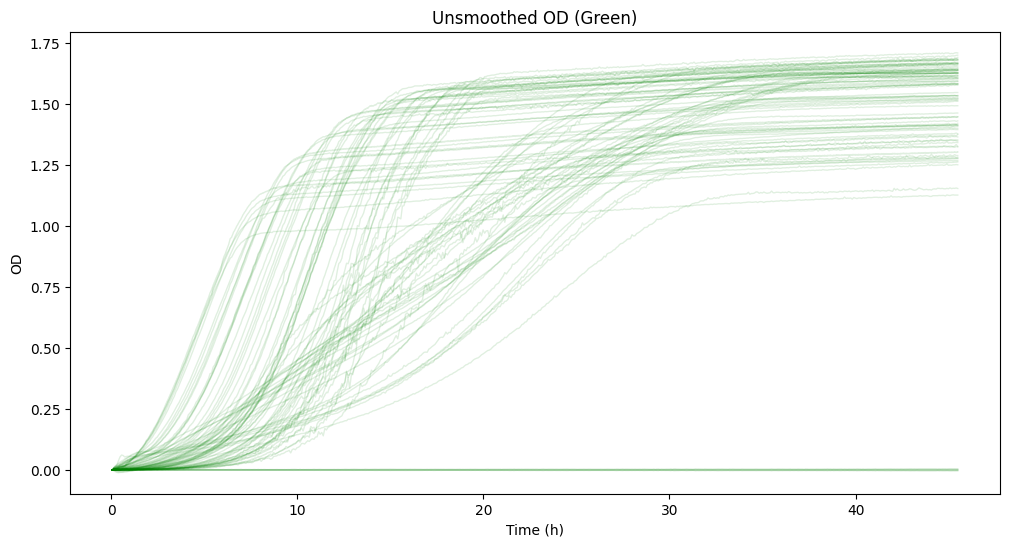

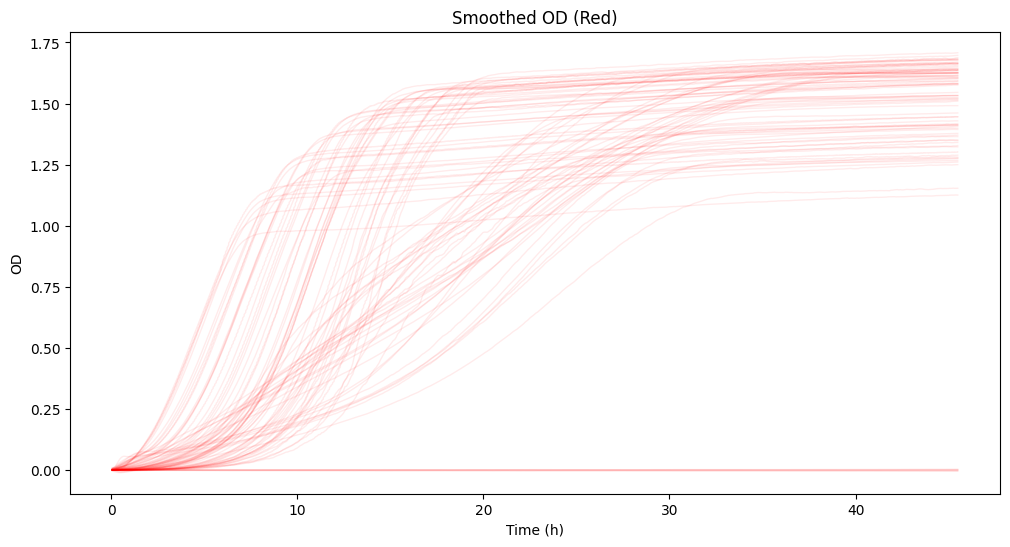

Median noise raw   : 0.004604235725643085
Median noise smooth: 0.0029052880615605754
Noise reduction %  : 36.89966729158319


In [89]:
# Load the dataset
absorb = pd.read_csv("abs.csv")
absorb.head()

cat = pd.read_csv("cat.csv")
cat.head()

gain_70 = pd.read_csv("gain_70.csv")
gain_70.head()  

new_rows = absorb.columns[2:-3]
df = pd.DataFrame()
df["well"]=new_rows

# Correcting the absorbance data

# Baseline correction for instrumental noise:
absorb["Time"] = pd.to_timedelta(absorb["Time"]).dt.total_seconds()/3600
well_cols = absorb.columns[absorb.columns.str.match(r"^[A-H](?:[1-9]|1[0-2])$")]
base=absorb["Time"].idxmin()
base_values = absorb.loc[base, well_cols]
absorb[well_cols] = absorb[well_cols] - base_values

# Blank subtraction 
abs_long = absorb[["Time", *well_cols]].melt(id_vars="Time", var_name="well", value_name="OD")
abs_long = abs_long.merge(cat[["well", "media_type", "function"]], on="well", how="left")

blank_ref = (
    abs_long[abs_long["function"]=="blank"]
    .groupby(["media_type", "Time"], as_index=False)["OD"]
    .mean()
    .rename(columns={"OD": "OD_blank"})
)

abs_long = abs_long.merge(blank_ref, on=["media_type", "Time"], how="left")
abs_long["OD"] = abs_long["OD"] - abs_long["OD_blank"]

# Smoothing (Savitzky-Golay per well)
def smooth_group(g):
    y = g["OD"].to_numpy()
    n = len(y)
    if n < 7:
        g["OD_smooth"] = y
        return g
    # odd window <= n
    win = min(11, n if n % 2 == 1 else n - 1)
    if win < 5:
        g["OD_smooth"] = y
    else:
        g["OD_smooth"] = savgol_filter(y, window_length=win, polyorder=2, mode="interp")
    return g

# Bad rows with missing OD (should not be many if any)
abs_long = abs_long.dropna(subset=["OD"])
# Smooth while keeping columns
abs_long = abs_long.sort_values(["well", "Time"])
abs_long["OD_smooth"] = (
    abs_long.groupby("well")["OD"]
    .transform(lambda s: s.rolling(window=5, center=True, min_periods=1).mean())
)
# double check with Lily because there should not be NaN showing for any well


#Compare raw corrected vs smoothed for a quick check
plt.figure(figsize=(12, 6))
for _, g in abs_long.groupby("well"):
    plt.plot(g["Time"], g["OD"],"g-", alpha=0.12, lw=1)
plt.xlabel("Time (h)")
plt.ylabel("OD")
plt.title("Unsmoothed OD (Green)")
plt.show()

plt.figure(figsize=(12, 6))
for _, g in abs_long.groupby("well"):
    plt.plot(g["Time"], g["OD_smooth"], "r-", alpha=0.08, lw=1)
plt.xlabel("Time (h)")
plt.ylabel("OD")
plt.title("Smoothed OD (Red)")
plt.show()

# Simple numeric noise check (median std of first differences)
noise_raw = abs_long.groupby("well")["OD"].apply(lambda s: np.nanstd(np.diff(s)))
noise_smooth = abs_long.groupby("well")["OD_smooth"].apply(lambda s: np.nanstd(np.diff(s)))
print("Median noise raw   :", float(np.nanmedian(noise_raw)))
print("Median noise smooth:", float(np.nanmedian(noise_smooth)))
print("Noise reduction %  :", float(100*(1 - np.nanmedian(noise_smooth)/np.nanmedian(noise_raw))))




1.2 Computing features and merge

In [92]:
'''
OD_init: Initial optical density (OD) measurement at time 0 at 600nm
OD_1h: OD measurement at 1 hour (lag phase)
OD_2h: OD measurement at 2 hours (lag phase)
OD_3h: OD measurement at 3 hours (early log phase)
OD_4h: OD measurement at 4 hours (early log phase)
growth_rate: Slope of the OD curve at 4 hours modelled with log scale
lag: Duration of the lag phase (time until OD starts to increase)
AUC_4h: Area under the OD curve from 0 to 4 hours
curvature_4h: Curvature of the OD curve at 4 hours : slope of (0-2)hours - slope of (2-4)hours
'''
# Merge medita_type, OD_init
df_merged = df.merge(cat[['well',"OD_init","media_type","function"]], on='well', how='left')

# Merge OD_1h, OD_2h, OD_3h, OD_4h from the smoothed data
targets = [1.0,2.0, 3.0, 4.0]
parts = []

for t in targets:
    tmp = abs_long.dropna(subset=["OD"]).copy()
    idx = tmp.assign(diff=(tmp["Time"] - t).abs()).groupby("well")["diff"].idxmin()
    out = tmp.loc[idx, ["well", "OD"]].rename(columns={"OD": f"OD_{int(t)}h"})
    parts.append(out)

od_multi = parts[0]
for p in parts[1:]:
    od_multi = od_multi.merge(p, on="well", how="outer")
df_merged["well"] = df_merged["well"].astype(str).str.strip().str.upper()
od_multi["well"] = od_multi["well"].astype(str).str.strip().str.upper()

df_merged = df_merged.merge(od_multi, on="well", how="left")


# Merge specific growth rate
def calc_mu(g):
    x = g["Time"]
    y = g["OD_smooth"]
    # exponential region
    exp = (y > 0.01) & (y < 0.2) & x.notna() & y.notna()

    if exp.sum() < 5:
        return np.nan

    return np.polyfit(x[exp], np.log(y[exp]), 1)[0]

mu = (
    abs_long.groupby("well")
        .apply(calc_mu)
        .reset_index(name="specific_growth_rate")
)

df_merged = df_merged.merge(mu, on="well", how="left")

# Merge lag time period
def compute_lag(df):
    # Keep only valid rows and sort by time
    g = df[["Time", "OD_smooth"]].copy()
    g["Time"] = pd.to_numeric(g["Time"], errors="coerce")
    g["OD_smooth"] = pd.to_numeric(g["OD_smooth"], errors="coerce")
    g = g.dropna().sort_values("Time")

    # Ignore non-positive OD
    g = g[g["OD_smooth"] > 0].copy()
    if len(g) < 3:
        return pd.Series({"lag_time": np.nan})

    # Derivative from consecutive points: dOD/dt
    dt = g["Time"].diff()
    dOD = g["OD_smooth"].diff()
    g["slope"] = dOD / dt

    # Invalid derivative points
    g.loc[dt <= 0, "slope"] = np.nan

    # Rolling mean slope (~30 min)
    g["slope_roll"] = g["slope"].rolling(
        window=9, min_periods=3
    ).mean()

    # Above-threshold condition
    above = g["slope_roll"] > 0.002

    # Require persistence: >=2 consecutive windows above threshold
    persistent = above & above.shift(1, fill_value=False)

    if not persistent.any():
        return pd.Series({"lag_time": np.nan})

    lag_time = g.loc[persistent, "Time"].iloc[0]
    return pd.Series({"lag_time": lag_time})

# Apply per well
lag_df = abs_long.groupby("well", group_keys=False).apply(compute_lag).reset_index()
df_merged = df_merged.merge(lag_df, on="well", how="left")
# lag_df columns: well, lag_time

# Merge AUC_4h
import numpy as np

def compute_auc_4h(g):

    g = g.sort_values("Time")

    # keep 0–4 hr window
    g = g[(g["Time"] >= 0) & (g["Time"] <= 4)]

    if len(g) < 3:
        return np.nan

    t = g["Time"].to_numpy()
    y = g["OD_smooth"].to_numpy()

    # remove invalid values
    valid = (~np.isnan(t)) & (~np.isnan(y))
    t = t[valid]
    y = y[valid]

    if len(t) < 3:
        return np.nan

    return np.trapezoid(y, t)

auc_df = (
    abs_long.groupby("well")
    .apply(compute_auc_4h)
    .reset_index(name="AUC_4h")
)

df_merged = df_merged.merge(auc_df, on="well", how="left")

# Merge curvature_4h
def curvature_slope_diff(g):
    g = g.sort_values("Time")
    y = g["OD_smooth"]
    x = g["Time"]

    def slope_in_window(t0, t1):
        w = (x >= t0) & (x <= t1) & x.notna() & y.notna()
        if w.sum() < 3:
            return np.nan
        return np.polyfit(x[w].to_numpy(), y[w].to_numpy(), 1)[0]  # OD/hr

    m01 = slope_in_window(0, 2)
    m24 = slope_in_window(2, 4)

    if np.isfinite(m01) and np.isfinite(m24):
        return m24 - m01
    return np.nan
curv_df = (
    abs_long.groupby("well")
    .apply(curvature_slope_diff)
    .reset_index(name="curvature_4h")
)
df_merged = df_merged.merge(curv_df, on="well", how="left")
df_merged.head()





,well,OD_init,media_type,function,OD_1h,OD_2h,OD_3h,OD_4h,specific_growth_rate,lag_time,AUC_4h,curvature_4h
0,A1,0.62500,YPG,trial_2,0.0020,0.0085,0.0185,0.0380,0.558493,0.985278,0.047263,0.010894
1,A2,NaN,YPDG,blank,-0.0005,0.0000,-0.0005,-0.0005,NaN,NaN,-0.001807,0.000346
2,A3,0.15625,YPG,trial_3,0.0020,0.0045,0.0075,0.0160,0.551815,2.068611,0.022226,0.004428
3,A4,0.15625,YPDG,trial_1,0.0025,0.0060,0.0125,0.0235,0.566310,0.985278,0.032428,0.005801
4,A5,0.31250,YPG,trial_3,0.0020,0.0065,0.0135,0.0280,0.576717,0.985278,0.035119,0.008108


1.3 Compute Outcome and merge

In [95]:
'''outcome: final fluorescence /final OD (protein/cell) at ~45 hrs'''
# ---------- A) Wide fluorescence -> long ----------
# gain_70 wide format: Time + well columns (A1..H12)
well_cols = gain_70.columns[gain_70.columns.str.match(r"^[A-H](?:[1-9]|1[0-2])$")]

fl_long = gain_70[["Time", *well_cols]].melt(
    id_vars="Time", var_name="well", value_name="FL"
)
fl_long["Time"] = pd.to_timedelta(fl_long["Time"], errors="coerce").dt.total_seconds() / 3600

# attach metadata for blank correction
fl_long = fl_long.merge(cat[["well", "media_type", "function"]], on="well", how="left")

# ---------- B) fluorescence baseline + blank correction ----------
fl = fl_long.copy()
fl["FL"] = pd.to_numeric(fl["FL"], errors="coerce")

i0 = fl.groupby("well")["Time"].idxmin()
fl0 = fl.loc[i0, ["well", "FL"]].rename(columns={"FL": "FL_t0"})
fl = fl.merge(fl0, on="well", how="left")
fl["FL_base"] = fl["FL"] - fl["FL_t0"]

blank_ref = (
    fl[fl["function"].str.lower().eq("blank")]
    .groupby(["media_type", "Time"], as_index=False)["FL_base"]
    .mean()
    .rename(columns={"FL_base": "FL_blank"})
)

fl = fl.merge(blank_ref, on=["media_type", "Time"], how="left")
fl["FL_corr"] = fl["FL_base"] - fl["FL_blank"]

# ---------- C) align to OD end time (earlier stop between FL and OD) ----------
od = abs_long.copy()
od_col = next(c for c in ["OD_smooth", "OD_bs", "OD"] if c in od.columns)
od["Time"] = pd.to_numeric(od["Time"], errors="coerce")
od[od_col] = pd.to_numeric(od[od_col], errors="coerce")

end_times = (
    fl.groupby("well", as_index=False)["Time"].max().rename(columns={"Time": "fl_end"})
    .merge(
        od.groupby("well", as_index=False)["Time"].max().rename(columns={"Time": "od_end"}),
        on="well",
        how="inner",
    )
)
end_times["t_end"] = end_times[["fl_end", "od_end"]].min(axis=1)

# last fluorescence at/before t_end
fl_pick = fl.merge(end_times[["well", "t_end"]], on="well", how="inner")
fl_pick = fl_pick[fl_pick["Time"] <= fl_pick["t_end"]]
idx_fl = fl_pick.groupby("well")["Time"].idxmax()
fl_final = fl_pick.loc[idx_fl, ["well", "FL_corr"]].rename(columns={"FL_corr": "final_fluor_corr"})

# last OD at/before t_end
od_pick = od.merge(end_times[["well", "t_end"]], on="well", how="inner")
od_pick = od_pick[od_pick["Time"] <= od_pick["t_end"]]
idx_od = od_pick.groupby("well")["Time"].idxmax()
od_final = od_pick.loc[idx_od, ["well", od_col]].rename(columns={od_col: "final_OD"})

# ---------- D) final outcome ----------
final_df = (
    end_times[["well", "t_end"]]
    .merge(fl_final, on="well", how="left")
    .merge(od_final, on="well", how="left")
)
final_df["outcome"] = np.where(
    final_df["final_OD"] > 0,
    final_df["final_fluor_corr"] / final_df["final_OD"],
    np.nan
)

df_merged["outcome"] = df_merged["well"].map(final_df.set_index("well")["outcome"])
df_merged.head()






,well,OD_init,media_type,function,OD_1h,OD_2h,OD_3h,OD_4h,specific_growth_rate,lag_time,AUC_4h,curvature_4h,outcome
0,A1,0.62500,YPG,trial_2,0.0020,0.0085,0.0185,0.0380,0.558493,0.985278,0.047263,0.010894,15513.165403
1,A2,NaN,YPDG,blank,-0.0005,0.0000,-0.0005,-0.0005,NaN,NaN,-0.001807,0.000346,NaN
2,A3,0.15625,YPG,trial_3,0.0020,0.0045,0.0075,0.0160,0.551815,2.068611,0.022226,0.004428,13440.610639
3,A4,0.15625,YPDG,trial_1,0.0025,0.0060,0.0125,0.0235,0.566310,0.985278,0.032428,0.005801,1466.503518
4,A5,0.31250,YPG,trial_3,0.0020,0.0065,0.0135,0.0280,0.576717,0.985278,0.035119,0.008108,14355.654647
